### Interpolate fluorimeter data with unknown time shift on CTD time (add fluorimeter to CTD)

In [1]:
import sys
from pathlib import Path
import logging
from typing import Any, AnyStr, Callable, Dict, Iterable, Iterator, Mapping, Match, Optional, Union, Sequence, Tuple, TypeVar
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.ndimage import gaussian_filter1d
from IPython.display import display
# importing my functions
drive_d = 'D:' if sys.platform == 'win32' else '/mnt/D'  # to run on my Linux/Windows systems both
scripts_path = Path(drive_d + '/Work/_Python3/And0K/h5toGrid')
sys.path.append(str(Path(scripts_path).resolve()))
from to_pandas_hdf5.h5toh5 import h5log_rows_gen  # this requires pytables

l = logging.getLogger()
%matplotlib inline
rcParams['axes.grid'] = True

# Paths

In [2]:
path_db = Path(r'd:\WorkData\BlackSea\220920\220920.h5')
# Data tables
device = 'CTD_Idronaut_OS316'
add_col = 'Chl-a'  # col name and table name - need interpolate to data in CTD_...
tbl = f'/{device}'
tbl_log = f'{tbl}/logRuns'
tbl_add = f'/{add_col}'
tbl_add_log = f'{tbl_add}/logFiles'

# Loading data functions

In [3]:
qfmt = "index>=Timestamp('{}') and index<=Timestamp('{}')"
qfmt_search_log_row = "index<=Timestamp('{}') and DateEnd>=Timestamp('{}')"

def load_logged_interval(store, tbl_log, time_find, columns, tbl=None, i_select=0):
    """
    Load data from tbl having index between edges that are specified in tbl_log row.
    Row is the 1st row found in tbl_log where ``row's index`` < ``time_find`` < ``row's DateEnd``
    :param tbl: str, by default, parent of tbl_log
    :param i_select: if more than 1 log row found then select this item
    
    Data from tbl will be loaded of length ('rows' + rows_filtered) rows starting from its datetime index coordinate 
    that is equal to found log row datetime index 
    """
    df_log = store.select(tbl_log, where=qfmt_search_log_row.format(time_find, time_find))
    if tbl is None:
        tbl = tbl_log.rsplit('/', 1)[0]
        if not tbl:
            raise(KeyError(f'Can not extract parent of {tbl_log}'))
        l.debug(f'Loading {columns} from {tbl}...')
    
    if l.isEnabledFor(logging.DEBUG):  # level < 30:
        l.debug(f'Requested row(s) in {tbl_log} found:')
        display(df_log)
    df_log_sel = df_log.iloc[[i_select] if isinstance(i_select, int) else i_select, :]

    if (df_log_len := df_log.shape[0]) > 1:
        l.info(f'Selected row(s) {i_select} among found {df_log_len} log records:')
        display(df_log_sel)

    if len(df_log_sel) == 1:
        qstr = qfmt.format(*list(df_log_sel.DateEnd.items())[0])  # using index as a start date
        ind_st = store.select_as_coordinates(tbl, qstr)[0]
        df = store.select(
            tbl, start=ind_st,
            stop=ind_st + df_log_sel[['rows', 'rows_filtered']].values.sum(),
            columns=columns
        )
        l.info(f'Loaded {columns} columns data:', df)  # of length len(df)   
        return df
    else:
        print('Not found log records containing time {}'.format(t))
    
# Number of runs we will determine as side effect to not return it on each gen_data() yield:
n_log_rows = None


def gen_data() -> Iterator[Tuple[int, dict, np.recarray, np.recarray]]:
    """
    :return: iterator of run data (i_row, log_d, r, r_add):
    - i_row: log row number,
    - log_d: dict having tbl_log column names as keys: log row data that is run metadata, 
    - r:     run data,
    - r_add: data of same run from table tbl_add.
    """
    global n_log_rows
    with pd.HDFStore(path_db, mode='r') as store:
        n_log_rows = store.get_storer(tbl_log).nrows  # store[tbl_log]
        for i_row, log_d in enumerate(h5log_rows_gen(table_log=tbl_log, db=store), start=1):  # min_time, max_time, range_query,
            qstr = qfmt.format(log_d['Index'], log_d['DateEnd'])
            l.info(f'Log row {i_row}. Loading {qstr}')
            # display(log_d)
            ind_st = store.select_as_coordinates(tbl, qstr)[0]
            df = store.select(
                tbl, start=ind_st,
                stop=ind_st + log_d['rows'] + log_d['rows_filtered'],
                columns=['Pres']
            )
            # Load data from add_col table (using interval from its log in the same way),
            # but select log row using criteria that it has metadata record of file time edges
            # around current run's mean time
            df_add = load_logged_interval(store, tbl_add_log, time_find=df.index[[0,-1]].mean(), columns=[add_col])
            df.index = df.index.tz_localize(None)
            df_add.index = df_add.index.tz_localize(None)
            r = df.to_records()
            r_add = df_add.to_records()
            yield i_row, log_d, r, r_add

In [4]:
# loading data of 1st run
iter_data = gen_data()
i_row, log_r, r, r_add = next(iter_data)       
taus = np.zeros(n_log_rows, dtype=np.float64)  # updated as side effect after we have 1st run data

In [5]:
# loading data of 2nd run
i_row, log_r, r, r_add = next(iter_data)

In [6]:

def ref_interp(r: pd.DataFrame, max_dt_s: float = 60) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray]:
    """
    Interpolates reference time array over regular intervals. Also returns shifts index range
    that is proportional to ``max_dt_s`` and inverse proportional to ``t_period`` we selecting here
    (from which we will select optimal shift after)
    :param r: reference dataframe/record with "Time" (may be irregular) and "Pres" columns
    :param max_dt_s: s, maximum shift for range we will search
    :return:
    - r_t - int "Time" (ns) with regular period t_period and,
    - r_p - "Pres" interpolated over r_t,
    - t_period - period of r_t,
    - i_shift_range - index shift range corresponded to -max_dt_s..+max_dt_s for range with period t_period
    """
    # Constant period of regular interval scale if no need to interpolate: 
    dt = np.diff(r_time:=r.Time.astype(np.int64))
    t_period = np.mean(dt)  # ns
    # max abs. difference beteen real data and index with const. period t_period
    max_index_instead_time_error = np.abs(np.arange(0, t_period*(r.Time.size - 0.5), t_period) - (r_time - r_time[0])).max()
    if max_index_instead_time_error*1E-9 > 5:  # need interp?
        # print(f"Max shift: {max_index_instead_time_error*1E-9}s of reference time comparing to constant period: {t_period*1E-9}s. Std: {np.std(dt)*1E-9}s. ")
        
        # Reference time array with constant period that is nearly 2 times shorter
        t_period = round(t_period*1E-9, 1) * 1E9 / 2
        r_t = np.arange(*r.Time.astype(np.int64)[[0, -1]], t_period)
        print(f'New period of reference data: {t_period*1E-9}s, size: {r_t.size}')
        assert(dt.size*3 > r_t.size > dt.size)

        r_p = np.interp(r_t, r.Time.astype(np.int64), r.Pres)
    else:
        print('loaded data is nearly on regular interval scale')
        r_t = r.Time.astype(np.int64)
        r_p = r.Pres

    # search index range:
    i_shift_range = np.arange(*max_dt_s*1E9/t_period * np.int32([-1, 1]), dtype=np.int32)  # ns.
        
    return r_t, r_p, t_period, i_shift_range

r_t, r_p, t_period, i_shift_range = ref_interp(r)

loaded data is nearly on regular interval scale


# 

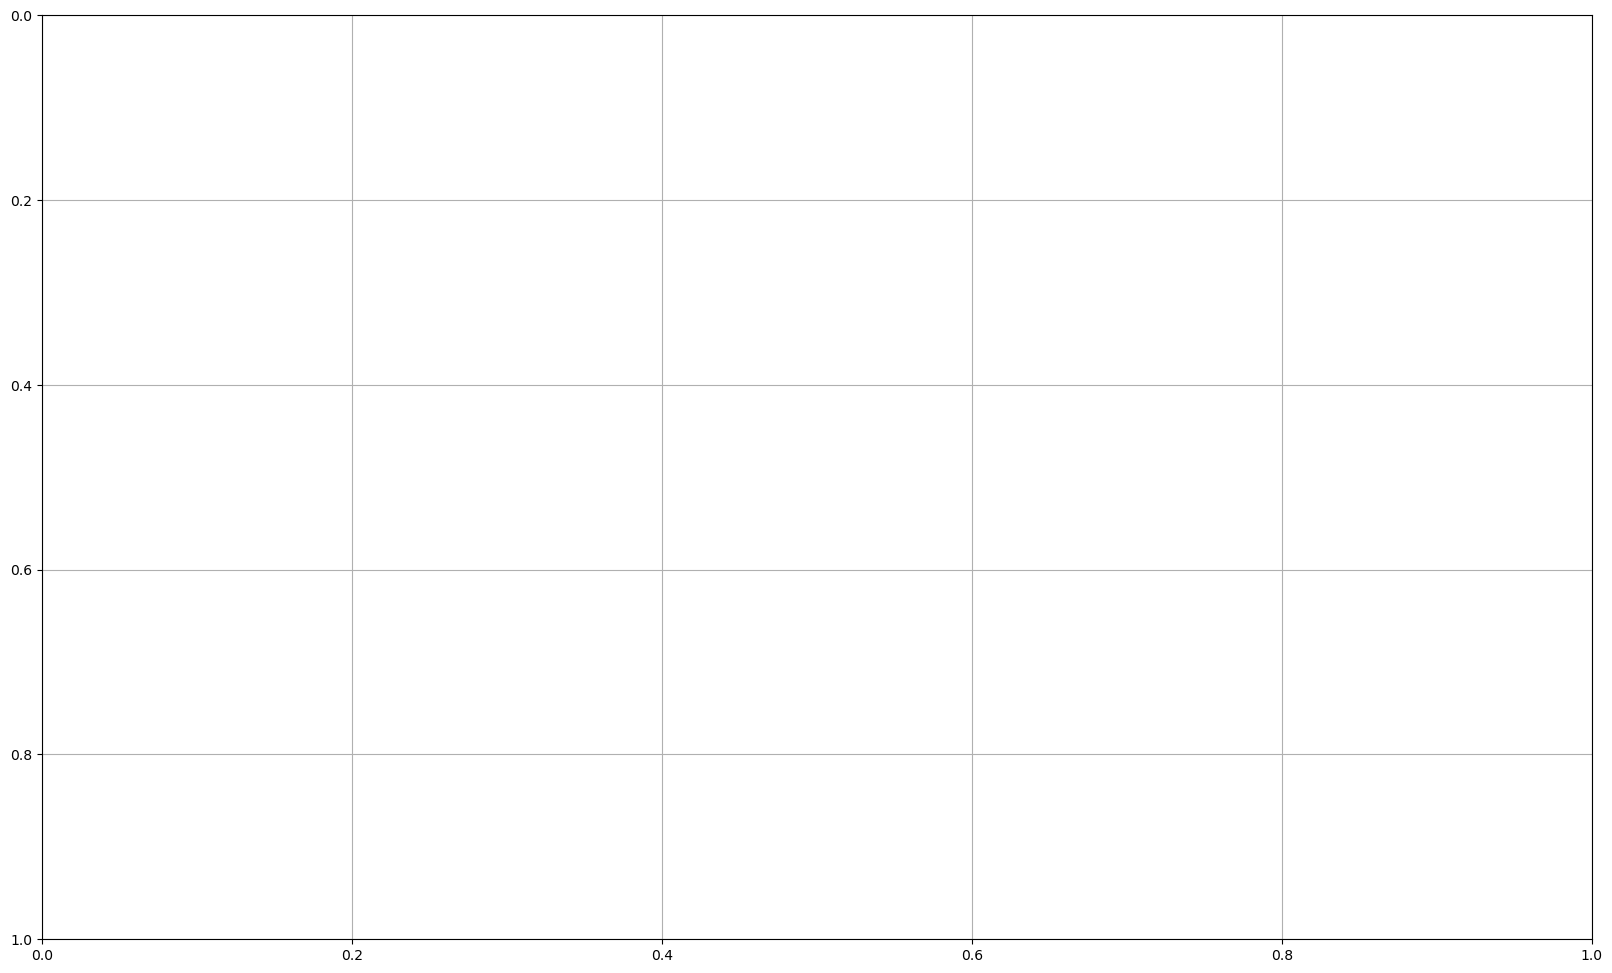

In [7]:
fig, ax = plt.subplots(figsize=(20,12)); ax.yaxis.set_inverted(True)
# for r, df, df_add in gen_data():
if True:   
    tmin = log_r['Index']
    tmax = log_r['DateEnd']
    #dt_start = tmin - r_t
    imin, imax = np.searchsorted(r_t, np.array([tmin.tz_localize(None), tmax.tz_localize(None)], 'M8[ns]').astype(np.int64));
    imin = imin.item(); imax = imax.item();  # to can view value in bad jupyter debugger
    iend = -1
    pmax = log_r['Pres_en']
    
    add_p = r_add[add_col]
    add_t = r_add.Time.astype(np.int64)
    itrp0 = np.interp(r_t, add_t, add_p)
    
if False:
    # Window RJ-4c:
    w = dtw.rabinerJuangStepPattern(4, "c")
    # (check w.plot()) to:
    # - keep a reference curve unchanged (only shift and stretch a query curve)
    # - constrain how many elements are duplicated
    # - keep both start and end open
    dtw(ref_curve, query_curve, step_pattern=w, open_end=True, open_begin=True)
    # Other variants: step_pattern=mvmStepPattern(10) / asymmetric / asymmetricP2
    # asymmetricP2 recursion is also similar to RJ-4c, but with a more constrained slope.
if False:       
    # bad method tried:  
    # Find best shift of add_t relative to r_t by searching pressure that should be the same for 2 points where
    # we first detect surface nearest to add_p = max(add_p) i.e. there we guess: add_p == 0. 
    t_when_0 = add_t[add_p==0]
    # time of max(add_p)
    t_when_max = add_t[np.argmax(add_p)]
    try:
        # Points that shoud be at the same depth (near to 0):
        # last time when add_p==0 before max(add_p):
        t_down_0 = t_when_0[t_when_0 < t_when_max][-1]
        # 1st time when add_p==0 after max(add_p):
        t_up_0 = t_when_0[t_when_0 > t_when_max][0]
        # dt_0_s = (t_up_0 - t_down_0)*1E-9  # time difference between these moments
        
        # dt_0 = t_down_0 - r_t[0]
        # dt_0_s = np.int64(dt_0).astype('m8[ns]').astype('m8[s]')
        # print('dt from run start to 1st additional data:', dt_0_s,
        #       'is too big!' if abs(dt_0_s) > max_dt_s else 'is reasonable to try find shift...')
        
        # Indexes of detected add_p points in other device:
        st_en0 = np.int32(np.searchsorted(r_t, [t_down_0, t_up_0]))
        # print('initial indexes when parameter goes to 0:', st_en0, 'in run of length', r_t.size)
        # all possible start and end shifted indexes we can check:
        i_shift_range_good = i_shift_range[np.logical_and(
            0 <= st_en0[0] + i_shift_range, st_en0[-1] + i_shift_range < r_t.size)]
        print('loaded data alows to search shift in range, s:',
              ' - '.join(str(i) for i in i_shift_range_good[[0,-1]]*t_period/1E9))
        st_en = st_en0[:, None] + i_shift_range_good
        # di = i_en - i_st
        
        # Searching shift that gives minimum pressure difference between (shifted) t_down_0 and t_up_0
        i_shift = np.argmin(abs(np.diff(r_p[st_en])))  # for i_shift in i_shift_range]
        dt_shift = i_shift*t_period
        taus[i_row] = dt_shift * 1E-9  # s
        print(f'Time shift found: {taus[i_row]}s')
        itrp = np.interp(r_t, add_t + dt_shift, add_p)
        
        # plot
        lines = [
            ax.plot(itrp0[:imax], r_p[:imax], **{'color': 'k', 'alpha': 0.25, 'label': f'down_tau={0}'}),
            ax.plot(itrp0[imax:iend], r_p[imax:iend], **{'color': 'c', 'alpha': 0.5, 'label': 'up'}),

            ax.plot(itrp[:imax], r_p[:imax], **{'color': 'g', 'ls':'--', 'label': f'down_tau={taus[i_row]}'}),
            ax.plot(itrp[imax:iend], r_p[imax:iend], **{'color': 'b', 'ls':'--', 'label': 'up'})
        ]
        # plot inputed data too:
        #lines.append(ax.plot(r.O2[:imax], r.Pres[:imax], **{'color': 'r', 'ls':'--', 'label': 'down_source'}))
        #lines.append(ax.plot(r.O2[imax:iend], r.Pres[imax:iend], **{'color': 'm', 'ls':'--', 'label': 'up'}))
        ax.set_xlim(100, 500); ax.legend(prop={'size': 10}, loc='lower right');        
        fig
    except IndexError as e:
        print('No data to get shift of surface reach:', e)
        raise


In [179]:
run = df_log_sel.iloc[0]
r = df.to_records()
tmin = df_log_sel.index[0]
tmax = run.DateEnd
imin = np.searchsorted(r.Time, tmin.to_numpy());
imax = np.searchsorted(r.Time, tmax.to_numpy());
pmax = run.Pres_en
# find ending upper point because of rows_filtered is wrong
icross = imax + np.flatnonzero(np.diff(np.int8(r.Pres[imax:] > pmax/3))!=0)
iend = icross[0] + r.Pres[slice(*icross[:2])].argmin()
pmin = r.Pres[iend]
i_o2min = imax + r.O2[imax:iend].argmin()
o2min = r.O2[i_o2min]

print(icross)
print(f'run start [{imin}]:\t', r.Time[0], ', Pres = ', run.Pres_st,
      f'\nrun max [{imax}]:\t', r.Time[imax], ', Pres = ', pmax, ', O2 = ', r.O2[imax],
      f'\nrun end [{iend}]:\t', r.Time[iend], ', Pres = ', pmin, ', O2_min = ', o2min, f'[{i_o2min}]',
     sep='')
ts = ((tmax - tmin)/(imax - imin)).total_seconds()
print('sampling interval:', ts)
speed = gaussian_filter1d(np.ediff1d(r.Pres, 0)/np.ediff1d(r.Time.astype(np.int64)*1E-9, 1), 5)

[2632 4543]
run start [0]:	2021-07-04T06:56:29.550000000, Pres = 2.8163
run max [1295]:	2021-07-04T06:59:39.890000000, Pres = 94.3226, O2 = 10.075
run end [4147]:	2021-07-04T07:06:39.440000000, Pres = 0.3557, O2_min = 0.401[1482]
sampling interval: 0.14698


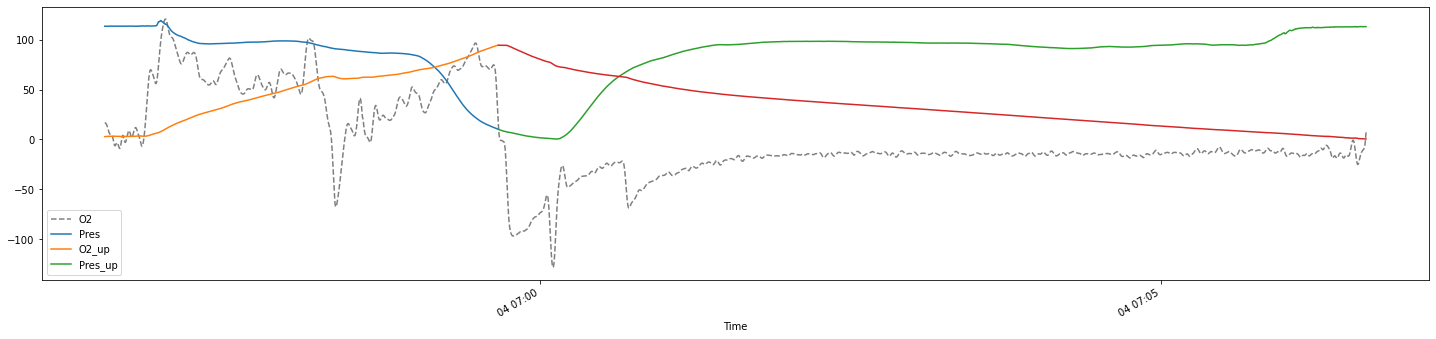

In [188]:
fig, ax = plt.subplots(figsize=(20,5))
# plt.tight_layout()
ax.plot(r.Time[:iend], 100*speed[:iend], **{'color': 'k', 'alpha':0.5, 'ls':'--', 'label': 'speed'})
df[['O2', 'Pres']].iloc[:imax].plot(ax=ax);
df[['O2', 'Pres']].rename(lambda c: f'{c}_up', axis=1).iloc[imax:iend].plot(ax=ax);


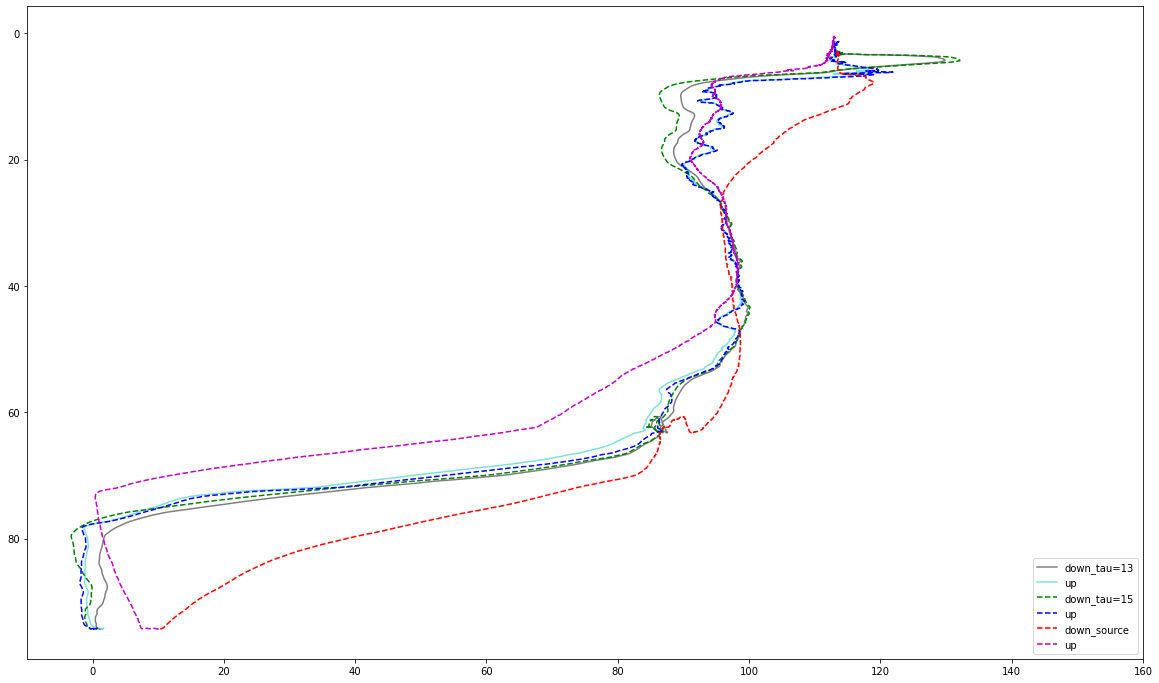

In [265]:
# Coefs of dynamic correction formula based on expected Time constants
def coefs_gain(tau):
    """ coefs (gain of differentiator)
    """
    phi = np.exp(-ts/tau) 
    pci = 1/(1 - phi)
    return pci, phi

# coefs of LPF:
tau0_lpf = 3  # time constant, s: bigger -> more smoothing
a0 = 1/(1 + 2*tau0_lpf/ts)
b0 = 1 - 2*a0

# correction functions
def f_cor_exp(out_p, in_p, in_i, pci, phi):
    """ Exponetiation
    suffixes: _p - previous, _i - carrent
    """
    out_i = pci*(in_i - phi*in_p)
    return out_i

def f_cor_lpf(out_p, in_p, in_i, a, b):
    """ Smoothing
    suffixes: _p - previous, _i - carrent
    """
    out_i = a*(in_i + in_p) + b*out_p
    return out_i

def f_cor_exp_lpf(out_p, in_p, in_i, pci, phi, a, b):
    return f_cor_lpf(out_p, in_p, f_cor_exp(out_p, in_p, in_i, pci, phi), a, b)
    
def run_f_cor(in_arr, fun, *args):
    """
    Runs sequentially fun(out_p, in_p, in_i, *args)
    args: other fun arguments
    """
    out_p = in_arr[0]
    out_list = [out_p]
    for in_p, in_i in zip(in_arr[:-1], in_arr[1:]):
        out_p = fun(out_p, in_p, in_i, *args)
        out_list.append(out_p)
    return out_list
    
def run_f_cor_speed(in_arr, fun, fun_tau, speed):
    """
    Runs sequentially fun(out_p, in_p, in_i, *args)
    fun_tau: fun_tau(speed) calculates fun arguments *args depending on speed
    """
    out_p = in_arr[0]
    out_list = [out_p]
    for in_p, in_i, speed_i in zip(in_arr[:-1], in_arr[1:], speed[:-1]):
        out_p = fun(out_p, in_p, in_i, *fun_tau(speed_i))
        out_list.append(out_p)
    return out_list

# o2_out = gaussian_filter1d(o2_exp_percents, 3)
o2_lpf = np.float32(run_f_cor(r.O2[:iend], f_cor_lpf, a0, b0))
o2_v = []  # variants
taus = [13, 15]
t_delay_counts = 35
t_delay = t_delay_counts * ts
for tau in taus:
    o2_exp = np.float32(run_f_cor(o2_lpf, f_cor_exp, *coefs_gain(tau)))
    o2_exp = np.hstack([o2_exp[t_delay_counts:], np.empty(t_delay_counts) + np.nan])
#     o2_exp = np.float32(run_f_cor_speed(
#         o2_lpf, f_cor_exp, lambda sp: coefs_gain(tau - tau_speed_coef*abs(sp)), speed
#     ))
    o2_v.append(gaussian_filter1d(o2_exp, 2))

fig, ax = plt.subplots(figsize=(20,12)); ax.yaxis.set_inverted(True)
lines = []

lines.append(ax.plot(o2_v[0][:imax], r.Pres[:imax], **{'color': 'k', 'alpha': 0.5, 'label': f'down_tau={taus[0]}'}))
lines.append(ax.plot(o2_v[0][imax:iend], r.Pres[imax:iend], **{'color': 'c', 'alpha': 0.5, 'label': 'up'}))

lines.append(ax.plot(o2_v[1][:imax], r.Pres[:imax], **{'color': 'g', 'ls':'--', 'label': f'down_tau={taus[1]}'}))
lines.append(ax.plot(o2_v[1][imax:iend], r.Pres[imax:iend], **{'color': 'b', 'ls':'--', 'label': 'up'}))
# plot inputed data too:
lines.append(ax.plot(r.O2[:imax], r.Pres[:imax], **{'color': 'r', 'ls':'--', 'label': 'down_source'}))
lines.append(ax.plot(r.O2[imax:iend], r.Pres[imax:iend], **{'color': 'm', 'ls':'--', 'label': 'up'}))
plt.xlim(-10, 160); ax.legend(prop={'size': 10}, loc='lower right');

In [264]:
figname = f"{r.Time[0].astype('M8[s]').item():%y%m%d_%H%M}O2cor-tau={','.join(str(t) for t in taus)};dalay={t_delay:.2g}s.png"
fig.savefig(path_db.with_name('_subproduct') / figname, format='png', dpi=300, transparent=False)
print(f'figure {figname} saved')

figure 210704_0656O2cor-tau=14,15;dalay=5.1s.png saved
